### Utils

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, cm
from mpl_toolkits.mplot3d import Axes3D

# Source : https://github.com/krasserm/bayesian-machine-learning/blob/dev/gaussian-processes/gaussian_processes_util.py
# ------------------------------------------
#  GPs for regression utils
# ------------------------------------------


def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sampled Function {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()


def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    ax = plt.gcf().add_subplot(1, 2, i, projection='3d')
    ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
    ax.scatter(X_train[:,0], X_train[:,1], Y_train, c=Y_train, cmap=cm.coolwarm)
    ax.set_title(title)


# ------------------------------------------
#  GPs for classification utils
# ------------------------------------------


def plot_data_1D(X, t):
    class_0 = t == 0
    class_1 = t == 1

    plt.scatter(X[class_1], t[class_1], label='Class 1', marker='x', color='red')
    plt.scatter(X[class_0], t[class_0], label='Class 0', marker='o', edgecolors='blue', facecolors='none')


def plot_data_2D(X, t):
    class_1 = np.ravel(t == 1)
    class_0 = np.ravel(t == 0)

    plt.scatter(X[class_1, 0], X[class_1, 1], label='Class 1', marker='x', c='red')
    plt.scatter(X[class_0, 0], X[class_0, 1], label='Class 0', marker='o', edgecolors='blue', facecolors='none')

    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')


def plot_pt_2D(grid_x, grid_y, grid_z):
    plt.contourf(grid_x, grid_y, grid_z, cmap='plasma', alpha=0.3, levels=np.linspace(0, 1, 11))
    plt.colorbar(format='%.2f')


def plot_db_2D(grid_x, grid_y, grid_z, decision_boundary=0.5):
    levels = [decision_boundary]
    cs = plt.contour(grid_x, grid_y, grid_z, levels=levels, colors='black', linestyles='dashed', linewidths=2)
    plt.clabel(cs, fontsize=20)


# ------------------------------------------
#  Sparse GP utils
# ------------------------------------------


def generate_animation(theta_steps, X_m_steps, X_test, f_true, X, y, sigma_y, phi_opt, q, interval=100):
    fig, ax = plt.subplots()

    line_func, = ax.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
    pnts_ind = ax.scatter([], [], label='Inducing variables', c='m')

    line_pred, = ax.plot([], [], label='Prediction', c='b')
    area_pred = ax.fill_between([], [], [], label='Epistemic uncertainty', color='r', alpha=0.1)

    ax.set_title('Optimization of a sparse Gaussian process')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-3, 3.5)
    ax.legend(loc='upper right')

    def plot_step(i):
        theta = theta_steps[i]
        X_m = X_m_steps[i]

        mu_m, A_m, K_mm_inv = phi_opt(theta, X_m, X, y, sigma_y)
        f_test, f_test_cov = q(X_test, theta, X_m, mu_m, A_m, K_mm_inv)
        f_test_var = np.diag(f_test_cov)
        f_test_std = np.sqrt(f_test_var)

        ax.collections.clear()
        pnts_ind = ax.scatter(X_m, mu_m, c='m')

        line_pred.set_data(X_test, f_test.ravel())
        area_pred = ax.fill_between(X_test.ravel(),
                                    f_test.ravel() + 2 * f_test_std,
                                    f_test.ravel() - 2 * f_test_std,
                                    color='r', alpha=0.1)

        return line_func, pnts_ind, line_pred, area_pred

    result = animation.FuncAnimation(fig, plot_step, frames=len(theta_steps), interval=interval)

    # Prevent output of last frame as additional plot
    plt.close()

    return result


### Basic intuitions behind gaussian processes

In [18]:
import numpy as np

def kernel(X1, X2, l=1.0, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)


In [19]:
def true_function(x):
    """The true underlying function we want to learn"""
    return np.sin(2 * np.pi * x) + 0.5 * np.sin(4 * np.pi * x)

def generate_data(n_train=20, n_test=100, noise_std=0.1, seed=42):
    """Generate training and test data"""
    np.random.seed(seed)
    
    # Training data
    X_train = np.random.uniform(0, 1, n_train).reshape(-1, 1)
    y_train = true_function(X_train).ravel() + np.random.normal(0, noise_std, n_train)
    
    # Test data (dense grid for visualization)
    X_test = np.linspace(0, 1, n_test).reshape(-1, 1)
    y_test = true_function(X_test).ravel()
    
    return X_train, y_train, X_test, y_test

In [20]:
from numpy.linalg import inv

def posterior(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    """
    Computes the suffifient statistics of the posterior distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (3)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (4)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s


Gaussian Processes is one way for us to convert a prior over functions to a posterior through observing the data. Here we show the basic intuition i.e. each possible function is a sample from the multivariate gaussian distribution with mean mu and covariance as kernel.

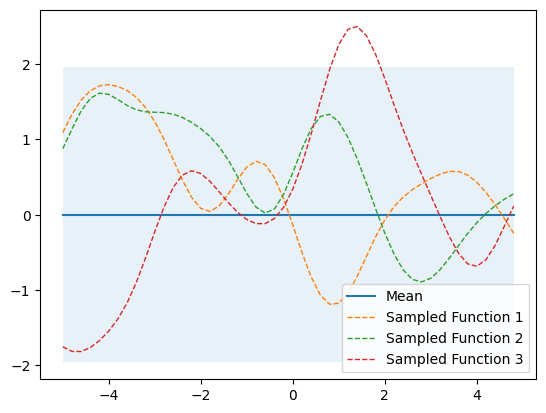

In [21]:
# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, uncertainty region and samples 
plot_gp(mu, cov, X, samples=samples)


Let's convert the prior to a posterior (i.e. we update the mu and kernel as we observe the data) and then sample the functions

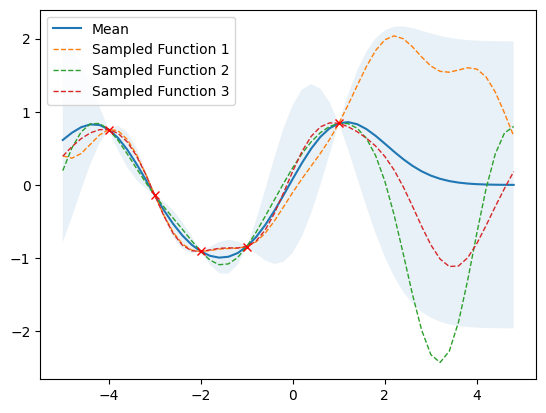

In [22]:
# Noise free training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train)

# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)


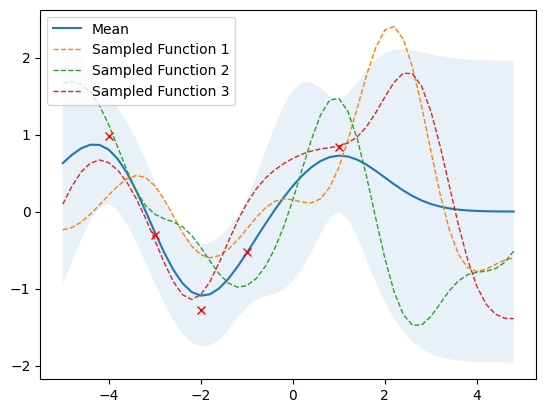

In [23]:
# Noisy training data
noise = 0.4
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)
